In [1]:
import sisl
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This example will setup the required electronic structures for usage in TBtrans.  
You will also learn the importance of perform $k$-point convergence tests for systems using TBtrans.  
We will continue with the graphene nearest neighbour tight-binding model and perform simple transport calculations using TBtrans.  
Our example will again concentrate on graphene:

In [3]:
graphene = sisl.geom.graphene(orthogonal=True)
H = sisl.Hamiltonian(graphene)

Hamiltonian{non-zero: 16, orthogonal: True,
 Spin{unpolarized, kind=f},
 Geometry{na: 4, no: 4,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
    Orbital{R: 1.43420, q0: 0.0}
   }: 4,
  },
  maxR: 1.43420,
  SuperCell{nsc: [3 3 1],
   A=[4.260, 0.000, 0.000],
   B=[0.000, 2.460, 0.000],
   C=[0.000, 0.000, 14.200],
  }
 }
}


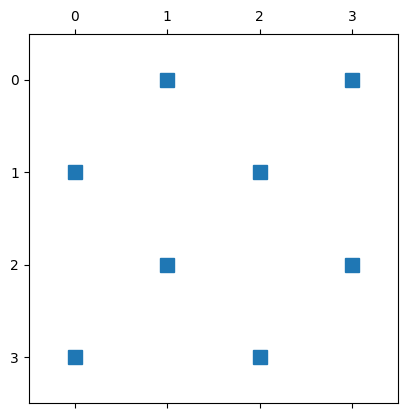

In [21]:
H.construct([[0.1, 1.43], [0., -2.7]])
print(H)
plt.spy(H.Hk())

Note that the above call of the graphene lattice is different from [TB 1](../TB_01/run.ipynb). In this example we will create an *orthogonal* graphene lattice, i.e. the lattice vectors are orthogonal to each other, unlike the minimal graphene lattice.  
The minimal orthogonal graphene lattice consists of 4 Carbon atoms.

Assert that we have 16 non zero elements:

In [9]:
print(H)

Hamiltonian{non-zero: 16, orthogonal: True,
 Spin{unpolarized, kind=f},
 Geometry{na: 4, no: 4,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.01070, maxR: 1.43420,
    Orbital{R: 1.43420, q0: 0.0}
   }: 4,
  },
  maxR: 1.43420,
  SuperCell{nsc: [3 3 1],
   A=[4.260, 0.000, 0.000],
   B=[0.000, 2.460, 0.000],
   C=[0.000, 0.000, 14.200],
  }
 }
}


The Hamiltonian we have thus far created will be our *electrode*. Lets write it to a TBtrans readable file:

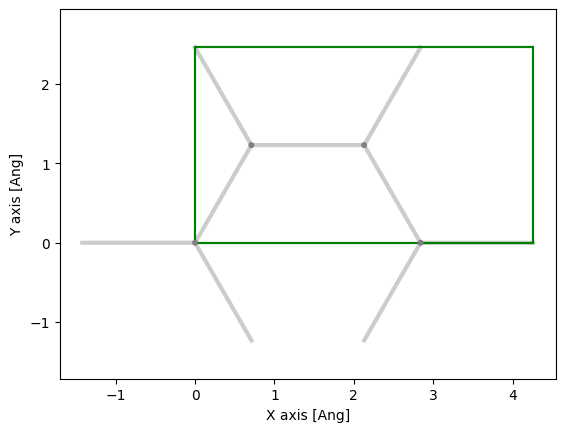

In [26]:
plot = H.geometry.plot(axes='xy')

In [11]:
H.write('ELEC.nc')

Now a file `ELEC.nc` file exists in the folder and it contains all the information (and more) that TBtrans requires to construct the self-energies for the electrode.

All that is required is now the device region.  
An important aspect of ***any*** transport setup is that the electrodes *must* **not** have matrix elements crossing the device region. I.e. there must not be matrix elements between any of the electrodes. This restriction is easily accommodated in tight-binding setups, but for DFT systems it is less transparent.  
In this tight-binding setup it simlpy means a repetition of the electrode 3 times; 1) left electrode, 2) scattering region, 3) right electrode.  

## 1. Creating the device, `Geometry`; `Hamiltonian`; `Hamiltonian.construct`

Here we tile the orthogonal graphene lattice 3 times along the second lattice vector (Python is 0-based) and subsequently construct it using the same parameters.  
This method of specifying all matrix elements is the most usable and easy scheme that is available in `sisl`.

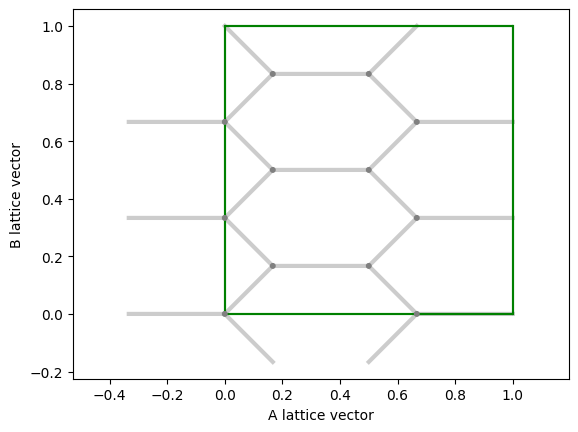

In [17]:
device = graphene.tile(3, axis=1)
device.plot(axes=(0, 1))
H_device = sisl.Hamiltonian(device)
H_device.construct([[0.1, 1.43], [0, -2.7]])
# plt.spy(H_device.Hk())

## 2. Creating the device, `Hamiltonian` $\to$ `Hamiltonian`

The `Geometry.tile` function is an explicit method to create bigger lattices from a smaller reference latice. Howewer, the `tile` routine is also available to the `Hamiltonian` object. Not only is it much easier to use, it also presents these advantages:

* It guarentees that the matrix elements are the same as the reference `Hamiltonian`, i.e. you need not specify the parameters to `construct` twice,
* It is *much* faster when creating $>500,000$ samples from smaller reference systems,
* It also requires less code which increases readability and is less prone to errors.

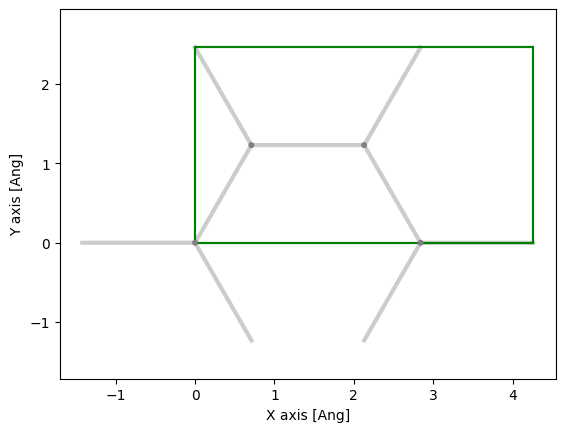

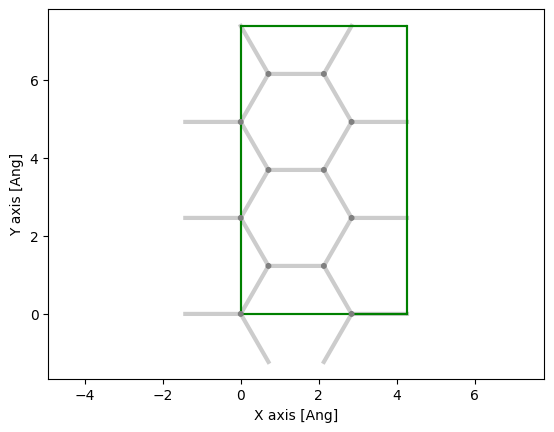

In [18]:
H_device = H.tile(3, axis=1)
p_prim = H.geometry.plot(axes='xy')
p_device = H_device.geometry.plot(axes='xy')

For more information you may execute the following lines to view the :

    help(Geometry.tile)
    help(Hamiltonian.tile)


Now we have created the device electronic structure. The final step is to store it in a TBtrans readable format:

In [19]:
H_device.write('DEVICE.nc')

Sometimes it may be convenient to plot the entries of the matrix to assert the symmetry and structure. The second line asserts that it is indeed a Hermitian matrix:

Hermitian deviation:  0.0


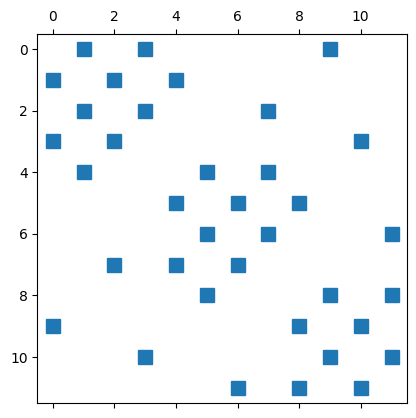

In [44]:
plt.spy(H_device.Hk())
print('Hermitian deviation: ',np.amax(np.abs(H.Hk() - H.Hk().T.conj())))

### First run of TBtrans

You should first run `tbtrans` like this (the `RUN.fdf` file is already prepared with enough input options for a successfull run):

    tbtrans RUN.fdf
    
After TBtrans is complete a number of files will be present:

- `siesta.TBT.nc`  
    The main data-file of TBtrans, this contains *all* calculated quantities, and everything that can be orbital resolved *is* orbital resolved, such as density of states.
    
- `siesta.TBT.CC`  
    The energy points at which TBtrans has calculated physical quantities.
    
- `siesta.TBT.KP`  
    Used $k$-points and their corresponding weights for integrating the Brillouin zone.
    
- `siesta.TBT.TRANS_Left-Right`  
    The $k$-resolved transmission from `Left` to the `Right` electrode. This is a consecutive list of transmissions for all energy points. Each $k$-point transmission is separated with a description of the $k$-point and its weight.
    
- `siesta.TBT.AVTRANS_Left-Right`  
    The $k$-averaged transmission from `Left` to the `Right` electrode. This is the $k$-averaged equivalent of `siesta.TBT.TRANS_Left-Right`.

In [28]:
tbt = sisl.get_sile('siesta.TBT.nc')

After calculating the transport properties of the transport problem you may also use `sisl` to interact with the TBtrans output (in the `*.TBT.nc` file):

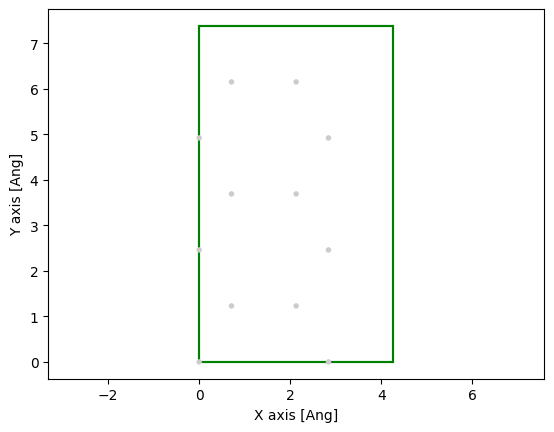

In [39]:
tbt.geometry.plot(axes='xy');

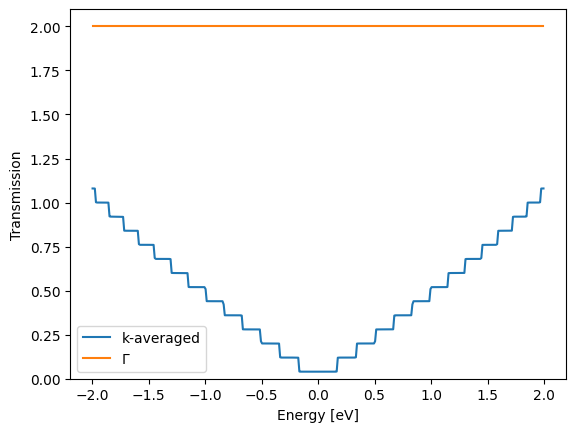

In [57]:
plt.plot(tbt.E, tbt.transmission(), label='k-averaged');
plt.plot(tbt.E, tbt.transmission(kavg=tbt.kindex([0, 0, 0])), label=r'$\Gamma$'); 
plt.xlabel('Energy [eV]'); plt.ylabel('Transmission'); plt.ylim([0, None]); plt.legend();

There are several function calls present in the above code:

* `get_sile`  
is a `sisl` function to read and parse *any* file that is enabled through `sisl`. You can check the documentation to find the available files. Here we use it to make `tbt` be an object with all the information that is present in the `siesta.TBT.nc` file.
* `tbt.transmission`  
is a function that retrieves the transmission function from the file. It has three optional arguments, the first two being the origin electrode and the second the absorbing electrode. They are defaulting to the first and second electrode.
* `tbt.transmission`  
takes a third and optional argument, if `True`, or not specified, it returns the **k** averaged transmission, else one may provide an array of integers that represent the internal k-points. I.e. the code above searches for the **k**-index of the $\Gamma$ point, and requests only that sampled transmission function.

You will see a *very* crude step-like transmission function.  

- Why is it not smooth, V-shaped (as it should be)? Can you change something to obtain a smooth transmission function?  
- Why is the $\Gamma$ transmission a fixed non zero value? Should it be zero somewhere?
  *HINT: checkout the energies used for evaluating the transmission function*.

The `siesta.TBT.nc` file also contains two different density-of-states quantities. How do they differ?

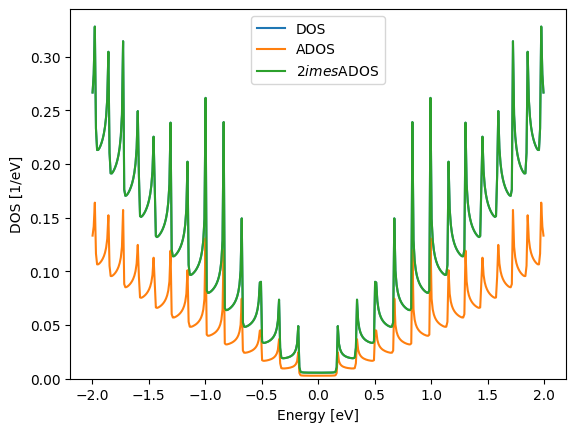

In [58]:
plt.plot(tbt.E, tbt.DOS(), label='DOS'); 
plt.plot(tbt.E, tbt.ADOS(), label='ADOS'); 
plt.plot(tbt.E, 2*tbt.ADOS(), label='2$\times$ADOS'); 
plt.xlabel('Energy [eV]'); plt.ylabel('DOS [1/eV]'); plt.ylim([0, None]); plt.legend();

`sisl` is capable of interacting *much* more with TBtrans output in various ways. We will return to this in later examples.

## Exercises

- Go to `In [4]` and change `H.write('ELEC.nc')` to `H.write('ELEC.TSHS')`, then adapt `RUN.fdf` file to let the left electrode read the electronic structure from the `TSHS` file instead. Redo the calculation and check if the output is the same.
- Try and change the on-site term of _one_ of the device atoms, then redo the calculation. What is the (periodic) effect of changing the on-site for one atom? (difference should be larger than `0.5 eV`)
- Try and create a big graphene flake with an associated Hamiltonian 100,000 atoms. When doing this it is essential you only construct the minimal graphene flake (otherwise creating such a big Hamiltonian will take several minutes). Then use `tile` or `repeat` to expand to the big system. If you try to run transport on this device it will take forever, and may even crash. To handle such big systems you may use the fdf-flag `TBT.Atoms.Device` to limit the calculation region (advice is to *not* do the calculation). 

## Learned lessons

- Easy creation of Hamiltonians with constant parameter (`Hamiltonian.construct`)
- Creation of the Hamiltonian using `Hamiltonian.tile` for *very* large systems.
- Saving the electronic structure in various formats (`Hamiltonian.write`)
- Data extraction from `*.TBT.nc` file (`tbt.DOS`, `tbt.ADOS`)